# Analysis of the autism data

Template exp:
Records n 7 

In [ ]:
run init.ipynb

# 2) Results and subgroups analysis

#### Functions definition

In [146]:
from model.xgboost.visualization import plot_roc_curves_xgboost
from metrics import f1score, average_precision, bestf1score, calc_auprg, create_prg_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, plot_roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score, fbeta_score
import prg
def compute_results(y_true, y_pred, threshold, name='?', title=""):


    # Compute imbalance_ratio of our sample
    pi = y_true.mean()
    correction_factor = (pi*(1-REFERENCE_IMBALANCE_RATIO))/(REFERENCE_IMBALANCE_RATIO*(1-pi))
    
    # Compute first AUROC
    auroc = roc_auc_score(y_true, y_pred)

    # Compute the AUC-PR
    auc_pr = average_precision_score(y_true, y_pred)

    # Compute the AUC-PR Corrected
    auc_pr_corrected = average_precision(y_true, y_pred, pi0=REFERENCE_IMBALANCE_RATIO)

    # Compute the AUC-PR Gain
    auc_pr_g = prg.calc_auprg(prg.create_prg_curve(y_true, y_pred))

    # Compute the AUC-PR Gain corrected
    auc_pr_g_corrected = calc_auprg(create_prg_curve(y_true, y_pred, pi0=REFERENCE_IMBALANCE_RATIO))
    
    # Compute f1 and f2 scores
    f1 = fbeta_score(y_true, y_pred > threshold, beta=1) 
    f2 = fbeta_score(y_true, y_pred >= threshold, beta=2) 

    # Compute the F1 score
    #f1, _ = bestf1score(y_true, y_pred, pi0=None)

    # Compute the corrected F1 score
    #f1_corrected, _ = bestf1score(y_true, y_pred, pi0=REFERENCE_IMBALANCE_RATIO)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred >= threshold).ravel()

    # Compute corrected precision (ppv)
    ppv_corr = tp/(tp+correction_factor*fp)

    acc = (tp + tn) / (tp + tn + fp +  fn)
    mcc = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    tpr =  tp / (tp+fn)
    tnr = tn / (tn+fp)
    ppv = tp / (tp+fp)
    npv = tn / (tn+fn)
    fnr = fn / (tp+fn)
    
    # Compute corrected F1 and F2
    f1_c = 2*(ppv_corr*tpr)/(ppv_corr+tpr)
    
    beta = 2
    f2_c = (1+beta**2)*(ppv_corr*tpr)/(beta**2 * ppv_corr + tpr)

    performances_dict = {'AUROC':round(auroc, 3),
                        'AUC-PR': round(auc_pr, 3),
                        'AUC-PR-Gain': round(auc_pr_g, 3),
                        'AUC-PR-Corrected': round(auc_pr_corrected, 3),
                        'AUC-PR-Gain-Corrected' :round(auc_pr_g_corrected, 3),
                        'F1 score (2 PPVxTPR/(PPV+TPR))': round(f1, 3),
                        'F1 score Corrected': round(f1_c, 3),
                        'F2': round(f2, 3),
                        'F2 Corrected': round(f2_c, 3),
                        'Accuracy' : round(acc, 3),
                        'Matthews correlation coefficient (MCC)': round(mcc, 3),
                        'Sensitivity, recall, hit rate, or true positive rate (TPR)': round(tpr, 3),
                        'Specificity, selectivity or true negative rate (TNR)': round(tnr, 3),
                        'Precision or positive predictive value (PPV)': round(ppv, 3),
                        'Corrected Precision or positive predictive value (PPV)': round(ppv_corr, 3),
                        'Negative predictive value (NPV)': round(npv, 3),
                        'Miss rate or false negative rate (FNR)': round(fnr, 3),
                        'False discovery rate (FDR=1-PPV)': round(1-ppv, 3),
                        'False omission rate (FOR=1-NPV)': round(1-npv, 3),
                        'TP': tp,
                        'TN': tn,
                        'FP': fp,
                        'FN': fn,
                        }
    
    performances_df = pd.DataFrame(performances_dict, index=[name+'\n(N='+str(len(y_true))+')'])

    performances_df['TN'] = tn
    performances_df['TP'] = tp
    performances_df['FP'] = fp
    performances_df['FN'] = fn

    performances_df['TN_normalized'] = 100*tn/len(y_true)
    performances_df['TP_normalized'] = 100*tp/len(y_true)
    performances_df['FP_normalized'] =  100*fp/len(y_true)
    performances_df['FN_normalized'] =  100*fn/len(y_true)    
    performances_df['N'] = len(y_true) 
    performances_df['y_true'] = [y_true]
    performances_df['y_pred'] = [y_pred]
    performances_df['Hanley_CI'] = performances_df['AUROC'] .apply(lambda x: compute_SD(x, np.sum(y_true==0), np.sum(y_true==1)))

    
    
    
    if False:
        display(performances_df)

        fig_mosaic = """
                        AB
                    """

        fig, axes = plt.subplot_mosaic(mosaic=fig_mosaic, figsize=(10,5))

        fig.suptitle(title, y=1.1, weight='bold', fontsize=12)

        cm = confusion_matrix(y_true, y_pred >= threshold)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues', ax=axes['B']);disp.im_.colorbar.remove()    

        # Plot the roc curves

        fpr, tpr, _ = roc_curve(y_true, y_pred); roc_auc = auc(fpr, tpr)
        axes['A'].plot(fpr, tpr, '-', color='darkorange', lw=1.5, label='ROC curve (area = %0.2f)' % roc_auc,)
        axes['A'].plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
        axes['A'].set_xlim([0.0, 1.0]); ax.set_ylim([0.0, 1.05]); axes['A'].grid()
        axes['A'].set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate')

        plt.tight_layout()
        plt.show()
    return performances_df


def plot_scatter_results(results, condition, xtickslabels=None, order=None, rotate=False, savefig=False):
    
    colors = plt.get_cmap('tab10')(np.arange(0,20))

    
    if xtickslabels is None:
        xtickslabels = sorted(results[condition].unique())
        
    if order is None:
        order = sorted(results[condition].unique())
        
    else:
        xtickslabels = order


    fig = plt.figure(figsize=(25, 8));ax = plt.gca()
    # loop over the curves (i.e. the metrics to be plotted)
    for j, metric_name in enumerate(results['metric_name'].unique()):

        color = colors[j]
        # loop over the x ticks  (i.e. the condition that is varying)
        for i, condition_value in enumerate(order):

            if metric_name == 'AUROC':
                plt.errorbar([i], 
                             results[(results['metric_name']==metric_name) &
                                        (results[condition]==condition_value)]['score'],
                             yerr=results[(results['metric_name']==metric_name) &
                                        (results[condition]==condition_value)]['Hanley_CI'], 
                             fmt='',
                             ecolor='grey',
                            # ecolor=color,
                             alpha=.5, 
                             capthick=2,
                             elinewidth=5,
                             capsize=15)
            plt.scatter([i], 
                         results[(results['metric_name']==metric_name) &
                                    (results[condition]==condition_value)]['score'],
                         marker='o',
                         s=100,
                         label=metric_name if i==0 else None, color=color)

    plt.grid(); plt.title("Performances when using or not the inidcator variables", weight='bold')
    #plt.ylabel(metric_name, weight='bold');
    plt.xlabel(condition, weight='bold');plt.xlim([-1, len(results[condition].unique())]); plt.ylim([-0.02, 1.02])
    plt.xticks(np.arange(len(results[condition].unique())), xtickslabels, rotation=90 if rotate else 0);plt.legend()
    if savefig:
        os.makedirs(os.path.join(DATA_DIR, 'figures'), exist_ok=True)
        plt.savefig(os.path.join(DATA_DIR, 'figures', savefig+'.png'), dpi=200, bbox_inches = 'tight')
            


    #fig = plt.figure(figsize=(25, 5));ax = plt.gca()
    #ax = sns.pointplot(data=results, x=condition, y="relative_score", hue='metric_name', hue_order=results['metric_name'].unique(), ci='sd', linestyles='-', ax = ax)
    #ax.set_title("Performances gain", weight='bold')
    #ax.axhline([0], color='tab:red', linestyle='-.');ax.legend(prop={'size':18})
    
    return

def having_missing(df, features, contrary=True):
    if not contrary:
        return df.loc[df.drop(index=df.dropna(subset=features, how='all').index).index, :]
    else:
        return df.dropna(subset=features, how='all')
    
    
def select(df, feat, value):
    return df[df[feat]==value]  

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, plot_roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score
def compute_SD(AUC, N1, N2):
    Q1=AUC/(2-AUC)
    Q2 = 2*AUC*AUC/(1+AUC)
    return(np.sqrt((AUC*(1-AUC)+(N1-1)*(Q1-AUC*AUC) + (N2-1)*(Q2-AUC*AUC))/(N1*N2)))

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

## Figure: Influence of the set of variables used

In [153]:
from utils import create_autism_df

df = create_autism_df(folder_names = ['TEST'])#'13_november_bis'])#'November 2022'])
df['Hanley_CI'] = df['AUROC'] .apply(lambda x: compute_SD(x, 417, 50))
df['tree_usage'] = df['tree_usage'].apply(lambda x: np.mean(x))

100%|██████████| 11/11 [00:02<00:00,  4.66it/s]


In [154]:
results_df_vertical = pd.DataFrame(columns = ['experiment_name', 'imputation_method', 'missing_data_handling', 'scale_data', 'n_features', 
                                              'sampling_method', 'max_depth',  'gamma', 'reg_lambda', 'learning_rate', 'n_estimators',
                                              'score', 'metric_name', 'TP', 'TN', 'FP', 'FN', 'y_true', 'y_pred', 'Hanley_CI'])

metrics_of_interest = ['AUROC', 'F1 score Corrected', 'Sensitivity', 'Specificity','PPV-Corr', 'TP', 'TN', 'FP', 'FN', 'Hanley_CI']
metrics_to_plot = ['AUROC', 'F1 score Corrected', 'Sensitivity', 'Specificity', 'PPV-Corr']#, 'Precision Corrected']

for exp, experiment_row in df.iterrows():
    
    for metric in metrics_of_interest:
        
        results_df_vertical = results_df_vertical.append({'experiment_name':experiment_row['experiment_name'], 
                                                                       'imputation_method':experiment_row['imputation_method'], 
                                                                       'missing_data_handling':experiment_row['missing_data_handling'], 
                                                                       'scale_data':experiment_row['scale_data'], 
                                                                       'n_features': experiment_row['n_features'], 
                                                                       'sampling_method': experiment_row['sampling_method'], 
                                                                       'max_depth': experiment_row['max_depth'], 
                                                                       'n_estimators': experiment_row['n_estimators'], 
                                                                       'gamma': experiment_row['gamma'], 
                                                                       'reg_lambda': experiment_row['reg_lambda'], 
                                                                       'learning_rate': experiment_row['learning_rate'], 
                                                                       'score':experiment_row[metric], 
                                                                       'metric_name':metric,
                                                                       'TP':experiment_row['TP'], 
                                                                       'TN':experiment_row['TN'], 
                                                                       'FP':experiment_row['FP'], 
                                                                       'y_true': [experiment_row['y_true']], 
                                                                       'y_pred': [experiment_row['y_pred']], 
                                                                       'Hanley_CI': experiment_row['Hanley_CI'], 
                                                                      }, ignore_index=True)
        
results_df_vertical.loc[results_df_vertical['metric_name']!='AUROC', 'Hanley_CI'] = 0

In [155]:
df

,dataset_name,experiment_number,experiment_name,approach,y_true,y_pred,missing_data_handling,imputation_method,features_name,n_features,use_missing_indicator_variables,scale_data,sampling_method,scenario,num_samples,max_depth,reg_lambda,gamma,learning_rate,n_estimators,imbalance_ratio,optimal_threshold,ratio_of_missing_values,ratio_missing_per_class_0,ratio_missing_per_class_1,resolution,bandwidth,estimation_time,num_cv,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1,F1 score Corrected,F2,F2 score Corrected,Accuracy,MCC,Sensitivity,Specificity,Precision,PPV,PPV-Corr,NPV,FNR,FDR,FOR,TP,TN,FP,FN,tree_usage,Hanley_CI
0,TEST,1,Weight sampling,xgboost,"[[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0,...","[[0.0042847968, 0.2594561875, 0.9955660701, 0....",imputation,constant,"['mean_gaze_percent_right', 'gaze_silhouette_s...",24,"{'PlayingWithBlocks': ['PWB_postural_sway', 'P...",False,without,multimodal_2023,388,3,0.1,0.1,0.15,200,0.14433,0.043234,0.083548,0.079317,0.108631,20,0.2,1.362605,10,0.877,0.618,0.931,0.247,0.939,0.701,0.168,0.701,0.320,0.838,0.525,0.804,0.843,0.464,0.464,0.107,0.962,0.196,0.536,0.038,45,280,52,11,118.7500,0.018957
1,TEST,9,Weight sampling,xgboost,"[[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0,...","[[0.0011464544, 0.0159438979, 0.9841430187, 0....",imputation,constant,"['mean_gaze_percent_right', 'gaze_silhouette_s...",24,"{'PlayingWithBlocks': ['PWB_postural_sway', 'P...",False,without,multimodal_2023,388,3,0.1,0.1,0.15,200,0.14433,0.033887,0.083548,0.079317,0.108631,20,0.2,1.429175,10,0.890,0.692,0.950,0.369,0.992,0.708,0.145,0.708,0.288,0.820,0.514,0.839,0.816,0.435,0.435,0.096,0.968,0.161,0.565,0.032,47,271,61,9,118.8750,0.017510
2,TEST,8,Weight sampling,xgboost,"[[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0,...","[[0.0015656584, 0.1529235095, 0.9917200804, 0....",imputation,constant,"['mean_gaze_percent_right', 'gaze_silhouette_s...",24,"{'PlayingWithBlocks': ['PWB_postural_sway', 'P...",False,without,multimodal_2023,388,3,0.1,0.1,0.15,200,0.14433,0.016920,0.083548,0.079317,0.108631,20,0.2,1.391671,10,0.877,0.641,0.935,0.303,0.988,0.696,0.129,0.696,0.264,0.791,0.483,0.857,0.780,0.397,0.397,0.083,0.970,0.143,0.603,0.030,48,259,73,8,118.4375,0.018957
3,TEST,3,Weight sampling,xgboost,"[[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0,...","[[0.0018446477, 0.2222195864, 0.945360899, 0.0...",imputation,constant,"['mean_gaze_percent_right', 'gaze_silhouette_s...",24,"{'PlayingWithBlocks': ['PWB_postural_sway', 'P...",False,without,multimodal_2023,388,3,0.1,0.1,0.15,200,0.14433,0.059182,0.083548,0.079317,0.108631,20,0.2,1.443111,10,0.883,0.670,0.943,0.341,0.991,0.705,0.168,0.705,0.320,0.843,0.534,0.804,0.849,0.474,0.474,0.110,0.962,0.196,0.526,0.038,45,282,50,11,119.6750,0.018295
4,TEST,4,Weight sampling,xgboost,"[[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0,...","[[0.001922201, 0.0442473851, 0.9718586802, 0.0...",imputation,constant,"['mean_gaze_percent_right', 'gaze_silhouette_s...",24,"{'PlayingWithBlocks': ['PWB_postural_sway', 'P...",False,without,multimodal_2023,388,3,0.1,0.1,0.15,200,0.14433,0.087265,0.083548,0.079317,0.108631,20,0.2,1.392122,10,0.890,0.673,0.949,0.371,0.993,0.703,0.145,0.703,0.284,0.853,0.543,0.786,0.864,0.494,0.494,0.119,0.960,0.214,0.506,0.040,44,287,45,12,118.4750,0.017510
5,TEST,5,Weight sampling,xgboost,"[[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0,...","[[0.0035671752, 0.2705259621, 0.9713860154, 0....",imputation,constant,"['mean_gaze_percent_right', 'gaze_silhouette_s...",24,"{'PlayingWithBlocks': ['PWB_postural_sway', 'P...",False,without,multimodal_2023,388,3,0.1,0.1,0.15,200,0.14433,0.012758,0.083548,0.079317,0.108631,20,0.2,1.389286,10,0.886,0.677,0.952,0.397,0.993,0.701,0.096,0.701,0.207,0.758,0.470,0.911,0.732,0.364,0.364,0.073,0.980,0.089,0.636,0.020,51,243,89,5,118.9375,0.017961
6,TEST,6,Weight sampling,xgboost,"[[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0,...","[[0.0008498641, 0.7792629004, 0.9988086224, 0....",imputation,constant,"['mean_gaze_percen

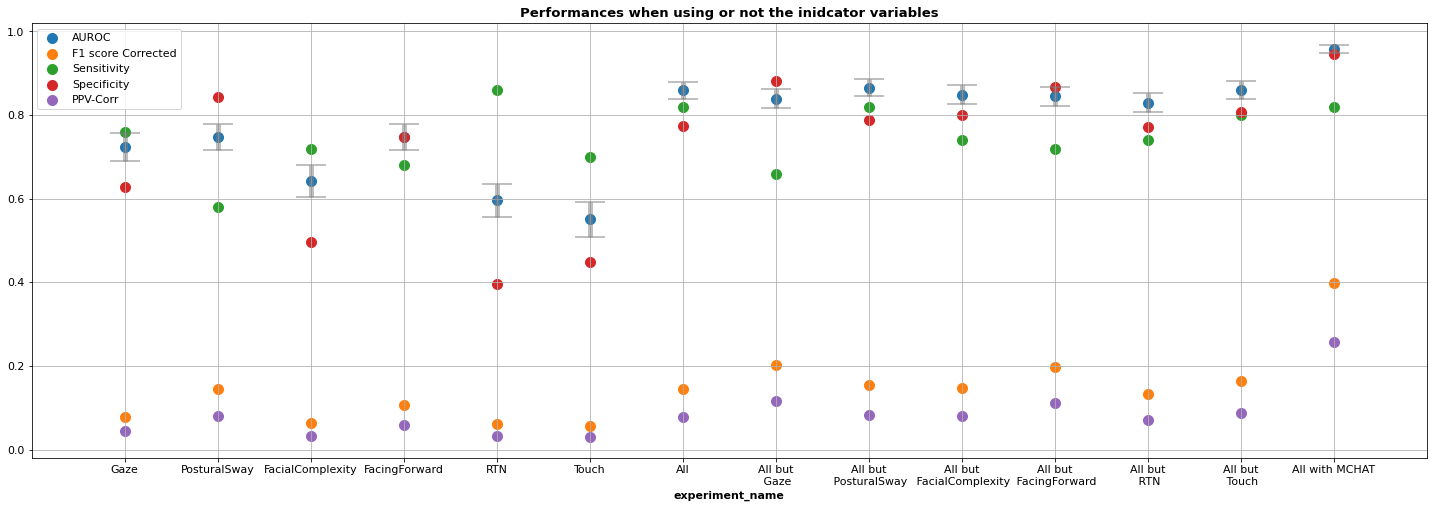

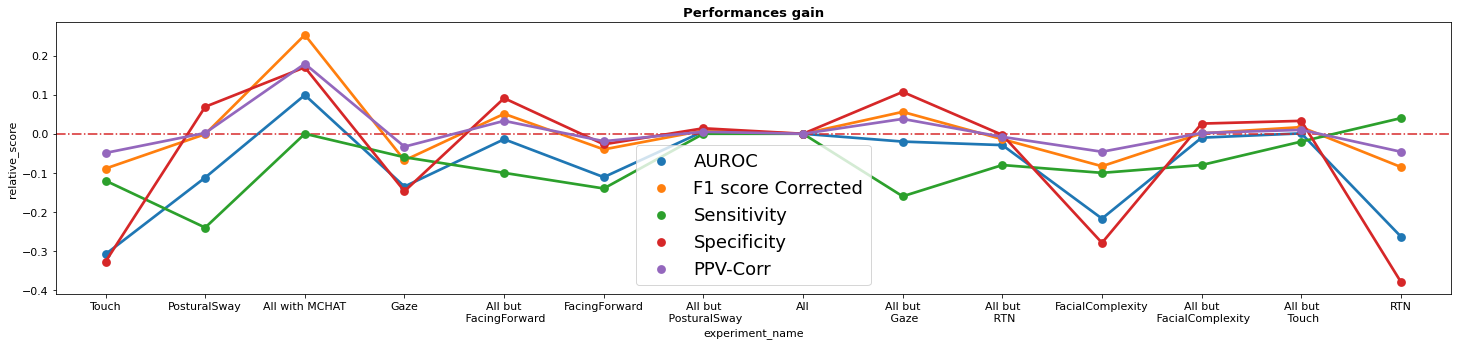

In [130]:
results = results_df_vertical[(results_df_vertical['experiment_name'].str.contains('Multimodal')) & (results_df_vertical['metric_name'].isin(metrics_to_plot))]
results['experiment_name'] = results['experiment_name'].apply(lambda x: x.replace('Multimodal ', ''))
results['experiment_name'] = results['experiment_name'].replace({name: name.replace('-', 'but\n') if '-' in name else 
                                                                 name.replace('but', 'but\n') if 'but' in name else 
                                                                 name.replace('but', 'but\n') for name in results['experiment_name'].unique()})
results['experiment_name'].unique()
results.reset_index(drop=True, inplace=True)
results['relative_score'] = np.nan

for idx, row in results.iterrows():
    
    baseline_score = results.loc[(results['experiment_name']=='All') & (results['metric_name']==row['metric_name']), 'score'].item()
    
    results.loc[idx, 'relative_score'] = (row['score']-baseline_score)#/baseline_score*100
order_multimodal = ['All', 'All - Gaze', 'All - RTN', 'All - PosturalSway', 'All - Touch', 'Gaze', 'RTN', 'PosturalSway', 'Touch']
order_multimodal = ['Gaze', 'PosturalSway', 'FacialComplexity', 'FacingForward', 'RTN', 'Touch', 'All', 'All but\n Gaze', 'All but\n PosturalSway', 'All but\n FacialComplexity', 'All but\n FacingForward', 'All but\n RTN', 'All but\n Touch', 'All with MCHAT']


condition = 'experiment_name'
plot_scatter_results(results, condition, xtickslabels=None, order=order_multimodal, rotate=False, savefig='features_comparison')
    
    

## Gathering the different subgroups results

**Creation of the final model to perfrom the subgroup analysis**

In [ ]:
xgboost_hyperparameters = {'scale_pos_weight':True,#np.sum(data.y_train==0)/np.sum(data.y_train==1), 
                            'max_depth' : 3,
                            'learning_rate' : 0.15, 
                            'gamma': 0.1,
                            'n_estimators': 200,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}
    
use_weight = True
if use_weight:
    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'weight_multimodal.npy'))
else:
    weighted_confidence_score = None
    
    
df =  pd.read_csv(AUTISM_DATA_PATH)

data = Dataset(df=df, 
               missing_data_handling='imputation',
               imputation_method='constant',
               sampling_method='without',
               scenario = 'multimodal_2023', 
               features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
               scale_data=False, 
               use_missing_indicator_variables=USE_MISSING_INDICATOR_PREDICTORS,
               verbosity=1, 
               proportion_train=1)

exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  experiment_folder_name='Final', 
                  model_hyperparameters=xgboost_hyperparameters,
                  experiment_name = 'Multimodal All',
                  verbosity=1, 
                  save_experiment=False)

random_state=np.random.randint(1000)
exp.fit_predict(num_cv=10, sample_weight=weighted_confidence_score, random_state=random_state)
exp.predictions_df['sample_weight'] = weighted_confidence_score
exp.plot()

**Initialize the result dataframe**

In [122]:
# init the result df for all the dataset
results = deepcopy(exp.performances_df)
results.index = ['All\n(N=467)']
for name in ['TP','FN', 'TN', 'FP']:
    results[name+'_normalized'] = 100*exp.predictions_df[name].mean().round(2)
results['N'] = len(exp.predictions_df)
results['y_true'] = [exp.predictions_df['y_true'].to_list()]
results['y_pred'] = [exp.predictions_df['y_pred'].to_list()]
results['Hanley_CI'] = results['AUROC'] .apply(lambda x: compute_SD(x, np.sum(exp.predictions_df['y_true']==0), np.sum(exp.predictions_df['y_true']==1)))


**Ablation per sex**

In [125]:
dataframe = deepcopy(exp.predictions_df)
for sex, sex_encoding in zip(['Male', 'Female'], ['M', 'F']):#[0,1]):
    
    d=dataframe.iloc[list(exp.dataset.df[exp.dataset.df['sex']==sex_encoding].index)]
    

    title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(d)/len(dataframe), len(d[d['y_true']==0]), len(d[d['y_true']==1]))
    
    y_true = d['y_true'].to_numpy()
    y_pred = d['y_pred'].to_numpy()
    res = compute_results(y_true, y_pred, exp.optimal_threshold, name=sex, title=title)
    results = results.append(res)

**Ablation per race and ethnicity**

In [99]:

exp.dataset.df.loc[exp.dataset.df['race'].isnull(), 'race'] = -1
for race, race_encoding in zip(['White/Caucasian', 'Black/African American', 'Other'], [0,1, 2]):
    
    d=dataframe.iloc[list(exp.dataset.df[exp.dataset.df['race']==race_encoding].index)]

    title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(d)/len(dataframe), len(d[d['y_true']==0]), len(d[d['y_true']==1]))
    
    y_true = d['y_true'].to_numpy()
    y_pred = d['y_pred'].to_numpy()

    res = compute_results(y_true, y_pred, exp.optimal_threshold, name=race, title=title)
    
    results = results.append(res)
    
        
for ethnicity, ethnicity_encoding in zip(['Not Hispanic/Latino', 'Hispanic/Latino'], [0,1]):
    
    d=dataframe.iloc[list(exp.dataset.df[exp.dataset.df['ethnicity']==ethnicity_encoding].index)]

    title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(d)/len(dataframe), len(d[d['y_true']==0]), len(d[d['y_true']==1]))
    
    y_true = d['y_true'].to_numpy()
    y_pred = d['y_pred'].to_numpy()

    res = compute_results(y_true, y_pred, exp.optimal_threshold, name=ethnicity, title=title)
    
    results = results.append(res)
    
    
   

**Ablation per age**

In [100]:
age_bins = [[17, 21], [21, 25], [25, 29], [29, 36], [36, 50]]
age_bins = [[17, 21], [21, 25], [25, 50]]

exp.dataset.df['age_bin'] = np.nan
for (low_age, high_age) in age_bins:
    
    age_name = 'Age (Months)\n{}-{}'.format(low_age, high_age)
    exp.dataset.df.loc[(exp.dataset.df['age'] >= low_age) & (exp.dataset.df['age'] < high_age), 'age_bin'] = age_name
    
    
        
for age_bin in exp.dataset.df['age_bin'].unique():
    
    d=dataframe.iloc[list(exp.dataset.df[exp.dataset.df['age_bin']==age_bin].index)]

    title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(d)/len(dataframe), len(d[d['y_true']==0]), len(d[d['y_true']==1]))
    
    y_true = d['y_true'].to_numpy()
    y_pred = d['y_pred'].to_numpy()

    res = compute_results(y_true, y_pred, exp.optimal_threshold, name=age_bin, title=title)
    
    results = results.append(res)
    
    

**Ablation per Mchat results**

In [101]:
res_without_mchat = exp.predictions_df.iloc[exp.dataset.df[exp.dataset.df['mchat_final'].isnull()].index]
y_true = res_without_mchat['y_true'].to_numpy()
y_pred = res_without_mchat['y_pred'].to_numpy()
res = compute_results(y_true, y_pred, exp.optimal_threshold, name='No MCHAT', title="")
results = results.append(res)


res_without_mchat = exp.predictions_df.iloc[exp.dataset.df[exp.dataset.df['mchat_result'] == 0].index]
y_true = res_without_mchat['y_true'].to_numpy()
y_pred = res_without_mchat['y_pred'].to_numpy()
res = compute_results(y_true, y_pred, exp.optimal_threshold, name='MCHAT Negative', title="")
results = results.append(res)

res_without_mchat = exp.predictions_df.iloc[exp.dataset.df[exp.dataset.df['mchat_result'] == 1].index]
y_true = res_without_mchat['y_true'].to_numpy()
y_pred = res_without_mchat['y_pred'].to_numpy()
res = compute_results(y_true, y_pred, exp.optimal_threshold, name='MCHAT Positive', title="")
results = results.append(res)

**Ablation per missing data patterns**

In [102]:
grouped_missing_features = {#'Floating Bubbles': ['FB_postural_sway', 'FB_postural_sway_derivative'],
                             #'DogInGrassC': ['DIGC_postural_sway', 'DIGC_postural_sway_derivative'],
                             #'DogInGrassRRL': ['DIGRRL_postural_sway', 'DIGRRL_postural_sway_derivative'],
                             #'SpinningTop': ['ST_postural_sway', 'ST_postural_sway_derivative'],
                            
                             #'PlayingWithBlocks': ['PWB_postural_sway', 'PWB_postural_sway_derivative'],
                             #'FunAtThePark': ['FP_postural_sway', 'FP_postural_sway_derivative', 
                                              #'FP_gaze_speech_correlation', 'FP_gaze_silhouette_score'], 

#                            'MechanicalPuppy': ['MP_postural_sway', 'MP_postural_sway_derivative'],
#                             'BlowingBubbles': ['BB_gaze_percent_right', 'BB_gaze_percent_right',
                                   #             'BB_postural_sway', 'BB_postural_sway_derivative'],
                            
                             'Social gaze': ['mean_gaze_percent_right'],
                             'Silhouette Score': ['gaze_silhouette_score'],    
                             'Gaze percent Right': ['mean_gaze_percent_right'],
                            
                            'S PosturalSway':['S_postural_sway'], 
                            'NS PosturalSway':['NS_postural_sway'], 
                            
                            'S PosturalSwayDerivative':['S_postural_sway_derivative'], 
                            'NS PosturalSwayDerivative':['NS_postural_sway_derivative'],                             
                            
                            # 'RhymesAndToys': ['RT_postural_sway', 'RT_postural_sway_derivative'],
                            # 'MakeMeLaugh': ['MML_postural_sway', 'MML_postural_sway_derivative'],
                            'S_postural_sway_complexity': ['S_postural_sway_complexity'],
                             'NS_postural_sway_complexity': ['NS_postural_sway_complexity'],
                            'S_facing_forward': [ 'S_facing_forward'],
                            'NS_facing_forward': [ 'NS_facing_forward'],
                            'S_eyebrows_complexity': [ 'S_eyebrows_complexity'],
                            'NS_eyebrows_complexity': [ 'NS_eyebrows_complexity'],
                            'S_mouth_complexity': [ 'S_mouth_complexity'],
                            'NS_mouth_complexity': [ 'NS_mouth_complexity'],

                            
                             'RTN': ['proportion_of_name_call_responses'],
                             'RTNDelay': ['average_response_to_name_delay'],
                             'Game administration': ['number_of_touches', 'number_of_target'],
                             'NoTouches': ['average_error','std_error']}
                            
                             #'Game administration': ['number_of_touches', 'number_of_target'],#, 'exploratory_percentage'],
                             #'NoTouches': ['average_length','std_length', 'pop_rate','average_touch_duration',
                             #                     'std_touch_duration', 'average_accuracy_variation', 'accuracy_consistency'],
                             #'TimeSpent': ['average_time_spent', 'std_time_spent']}

Social gaze 5.14% with 5.00 NT and 8.00 autistic
Silhouette Score 4.93% with 5.00 NT and 6.00 autistic
Gaze percent Right 5.14% with 5.00 NT and 8.00 autistic
S PosturalSway 4.71% with 5.00 NT and 6.00 autistic
NS PosturalSway 0.00% with 0.00 NT and 0.00 autistic
S PosturalSwayDerivative 4.71% with 5.00 NT and 6.00 autistic
NS PosturalSwayDerivative 0.00% with 0.00 NT and 0.00 autistic
S_postural_sway_complexity 4.71% with 5.00 NT and 6.00 autistic
NS_postural_sway_complexity 0.00% with 0.00 NT and 0.00 autistic
S_facing_forward 4.50% with 4.00 NT and 6.00 autistic
NS_facing_forward 0.00% with 0.00 NT and 0.00 autistic
S_eyebrows_complexity 4.71% with 5.00 NT and 6.00 autistic
NS_eyebrows_complexity 0.00% with 0.00 NT and 0.00 autistic
S_mouth_complexity 4.71% with 5.00 NT and 6.00 autistic
NS_mouth_complexity 0.00% with 0.00 NT and 0.00 autistic
RTN 0.86% with 1.00 NT and 2.00 autistic
RTNDelay 25.48% with 25.00 NT and 28.00 autistic
Game administration 28.27% with 29.00 NT and 24.00 

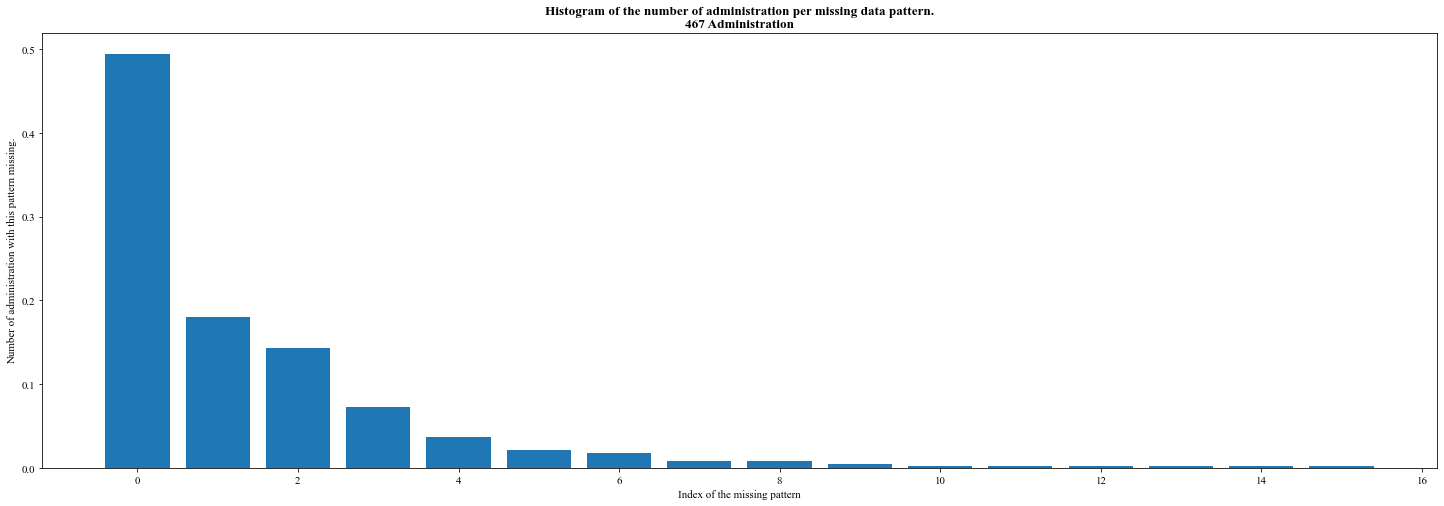

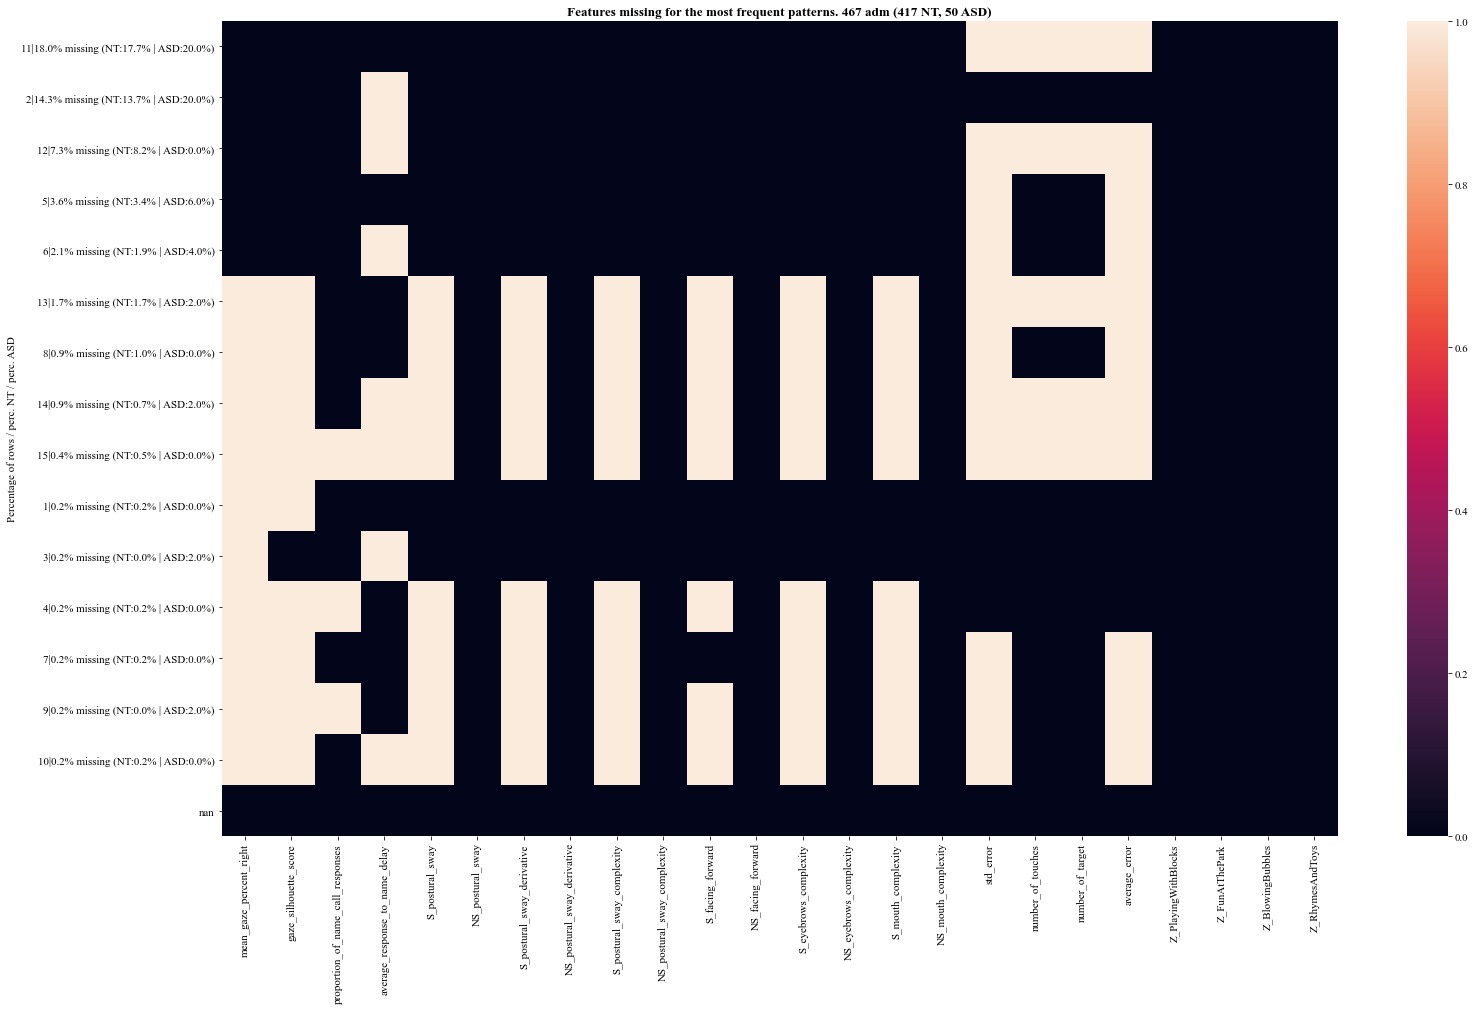

In [103]:

X  = deepcopy(exp.predictions_df[exp.features_name])
dataset = X.copy()

vars = dataset.dtypes.index.values
n_var = dataset.shape[1]

# set up missing data patterns
r = 1 * dataset.isnull()
mdp = np.dot(r, list(map(lambda x: pow(2, x), range(n_var))))
sorted_mdp = sorted(np.unique(mdp))
n_pat = len(sorted_mdp)
correct_mdp = list(map(lambda x: sorted_mdp.index(x), mdp))
exp.predictions_df["mdp"] = pd.Series(correct_mdp, index=dataset.index)



dataframe_missing = deepcopy(exp.predictions_df)
for name_missing, feature_missing  in grouped_missing_features.items():
    
    print("{} {:.2f}% with {:.2f} NT and {:.2f} autistic".format(name_missing, 100*len(having_missing(dataframe_missing, feature_missing, contrary=False))/len(dataframe_missing), 
                                                                 100*round(len(having_missing(select(dataframe_missing, 'y_true', 0), feature_missing, contrary=False))/len(select(dataframe_missing, 'y_true', 0)), 2), 
                                                                 100*round(len(having_missing(select(dataframe_missing, 'y_true', 1), feature_missing, contrary=False))/len(select(dataframe_missing, 'y_true', 1)), 2)))
    


plt.figure(figsize=(25, 8))
plt.bar(x=np.arange((len(dataframe_missing["mdp"].value_counts().index))), height=dataframe_missing["mdp"].value_counts(normalize=True).to_numpy())
plt.title("Histogram of the number of administration per missing data pattern.\n{} Administration".format(len(dataframe_missing)), weight='bold');plt.xlabel("Index of the missing pattern"); plt.ylabel("Number of administration with this pattern missing.")
print("Number of missing patterns: {}".format(n_pat))
matrix = pd.DataFrame(
            data=np.zeros(shape=(len(dataframe_missing["mdp"].value_counts().index), len(exp.features_name)+1)),
            columns=exp.features_name+['Percentage of rows'],
            index=dataframe_missing["mdp"].unique(),
        ).sort_index()

for pattern in sorted(dataframe_missing["mdp"].unique())[1:]:
    d = dataframe_missing.loc[dataframe_missing['mdp']==pattern, ['y_true'] + exp.features_name]
    missing_columns = list(d.columns[d.isnull().any()])
    matrix.loc[pattern, missing_columns] = 1
    matrix.loc[pattern, 'Percentage of rows'] = np.round(len(d)/len(dataframe)*100,2)
    #matrix.loc[pattern, 'Percentage of rows (autism)'] = np.round(len(d[d['diagnosis']==0])/len(data.df[data.df['diagnosis']==0])*100,2)
    #matrix.loc[pattern, 'Percentage of rows (NT)'] = np.round(len(d[d['diagnosis']==1])/len(data.df[data.df['diagnosis']==1])*100,2)
    matrix.loc[pattern, 'Percentage of rows / perc. NT / perc. ASD'] = "{}|{}% missing (NT:{}% | ASD:{}%)".format(pattern,np.round(len(d)/len(dataframe)*100,1), np.round(len(d[d['y_true']==0])/len(dataframe_missing[dataframe_missing['y_true']==0])*100,1), np.round(len(d[d['y_true']==1])/len(dataframe_missing[dataframe_missing['y_true']==1])*100,1))

matrix.sort_values('Percentage of rows', ascending=False, inplace=True)
plt.figure(figsize=(25, 15))
sns.heatmap(matrix.set_index('Percentage of rows / perc. NT / perc. ASD').loc[:, exp.features_name].astype(int))
plt.title("Features missing for the most frequent patterns. {} adm ({} NT, {} ASD)".format(len(dataframe_missing), len(dataframe_missing[dataframe_missing['y_true']==0]), len(data.df[dataframe_missing['y_true']==1])), weight='bold')


from metrics import f1score, average_precision, bestf1score, calc_auprg, create_prg_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, plot_roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score
import prg

dataframe = deepcopy(exp.predictions_df)
mapping_name = {0: "Complete", 
                11: "Only game missing", 
                12: "Game and Delay missing", 
                2: "Only delay missing"}
               # 11: "Game & Delay missing"}

#for mdp_index in mapping_name.keys():
#    d = dataframe[dataframe['mdp']==mdp_index]

for mdp_index in mapping_name.keys():
    d = dataframe_missing[dataframe_missing['mdp']==mdp_index]

    
    title = mapping_name[mdp_index]
    title+= " {:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(d)/len(dataframe_missing), len(d[d['y_true']==0]), len(d[d['y_true']==1]))
    
    y_true = d['y_true'].to_numpy()
    y_pred = d['y_pred'].to_numpy()
    
    try: 
        res = compute_results(y_true, y_pred, exp.optimal_threshold, name=mapping_name[mdp_index], title=title)
        results = results.append(res)
    except ValueError:
        pass
    
    



**Results for administrations having a compliance higher than .75**

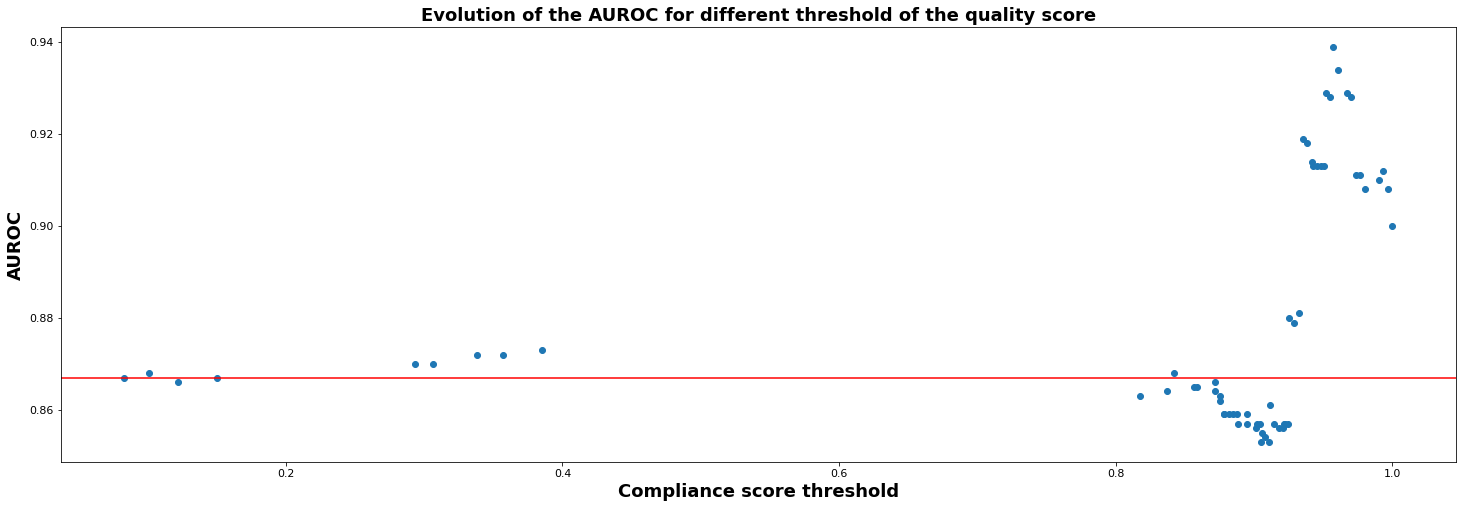

In [61]:

auroc = []
_, _, threshold = roc_curve(exp.sample_weight.astype(int), exp.sample_weight)

for th in threshold[1:]:
    d=dataframe.iloc[np.argwhere(exp.sample_weight >=th).flatten()]

    title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(d)/len(dataframe), len(d[d['y_true']==0]), len(d[d['y_true']==1]))

    y_true = d['y_true'].to_numpy()
    y_pred = d['y_pred'].to_numpy()

    res = compute_results(y_true, y_pred, exp.optimal_threshold, name='Complete\nAdministrations', title=title)
    res#ults = results.append(res)

    auroc.append(res['AUROC'].item())

fi(25, 8)
plt.title("Evolution of the AUROC for different threshold of the quality score", weight='bold', fontsize=18)
plt.ylabel("AUROC", weight='bold', fontsize=18)
plt.xlabel("Compliance score threshold", weight='bold', fontsize=18)
plt.axhline(auroc[-1], color='red', label='No threshold')

plt.scatter(threshold[1:], auroc)

In [76]:
d=dataframe.iloc[np.argwhere(exp.sample_weight >=.75).flatten()]

title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(d)/len(dataframe), len(d[d['y_true']==0]), len(d[d['y_true']==1]))

y_true = d['y_true'].to_numpy()
y_pred = d['y_pred'].to_numpy()

res = compute_results(y_true, y_pred, exp.optimal_threshold, name='Conclusive\nAdministrations', title=title)
results = results.append(res)



## Analysis of the results

In [87]:
final_results = deepcopy(results)

final_results.reset_index(inplace=True)
final_results.rename(columns={'Sensitivity, recall, hit rate, or true positive rate (TPR)':'Sensitivity', 
                       'Specificity, selectivity or true negative rate (TNR)':'Specificity', 
                       'Corrected Precision or positive predictive value (PPV)':'PPV-Corr', 
                       }, inplace=True)
final_results.rename(columns={'index': 'subgroup'}, inplace=True)
final_results['subgroup_name'] = final_results['subgroup'].apply(lambda x: x.split('\n')[0] if x.split('\n')[0]!='Age' else x.split('\n')[0] + '\n' + x.split('\n')[1])


results_vertical = pd.DataFrame(columns = ['subgroup', 'score', 'metric_name'])#, 'TP', 'TN', 'FP', 'FN', 'N'])

metrics_of_interest = ['AUROC', 'F1 score Corrected', 'Sensitivity', 'Specificity', 'PPV-Corr']#, 'TP', 'TN', 'FP', 'FN']
metrics_to_plot = ['AUROC', 'F1 score Corrected', 'Sensitivity', 'Specificity', 'PPV-Corr']

for _, experiment_row in final_results.iterrows():
    

    
    for metric in metrics_of_interest:
        
        results_vertical = results_vertical.append(pd.DataFrame({'subgroup':experiment_row['subgroup'], 
                                                                       'score':experiment_row[metric], 
                                                                       'metric_name':metric,
                                                                       'TP':experiment_row['TP'], 
                                                                       'TN':experiment_row['TN'], 
                                                                       'FP':experiment_row['FP'], 
                                                                       'FN':experiment_row['FN'], 
                                                                       'N': experiment_row['N'], 
                                                                       'Hanley_CI': experiment_row['Hanley_CI'],
                                                                       'y_true': [experiment_row['y_true']],
                                                                       'y_pred': [experiment_row['y_pred']]
                                                                      }, index=[0]))
        
results_vertical.reset_index(drop=True, inplace=True)
results_vertical['subgroup_name'] = results_vertical['subgroup'].apply(lambda x: x.split('\n')[0] if x.split('\n')[0]!='Age' else x.split('\n')[0] + '\n' + x.split('\n')[1])
results_vertical['N'] = results_vertical['N'].astype(int)
results_vertical['subgroup_raw'] = results_vertical['subgroup'].apply(lambda x: "\n".join(x.split('\n')[:-1]))


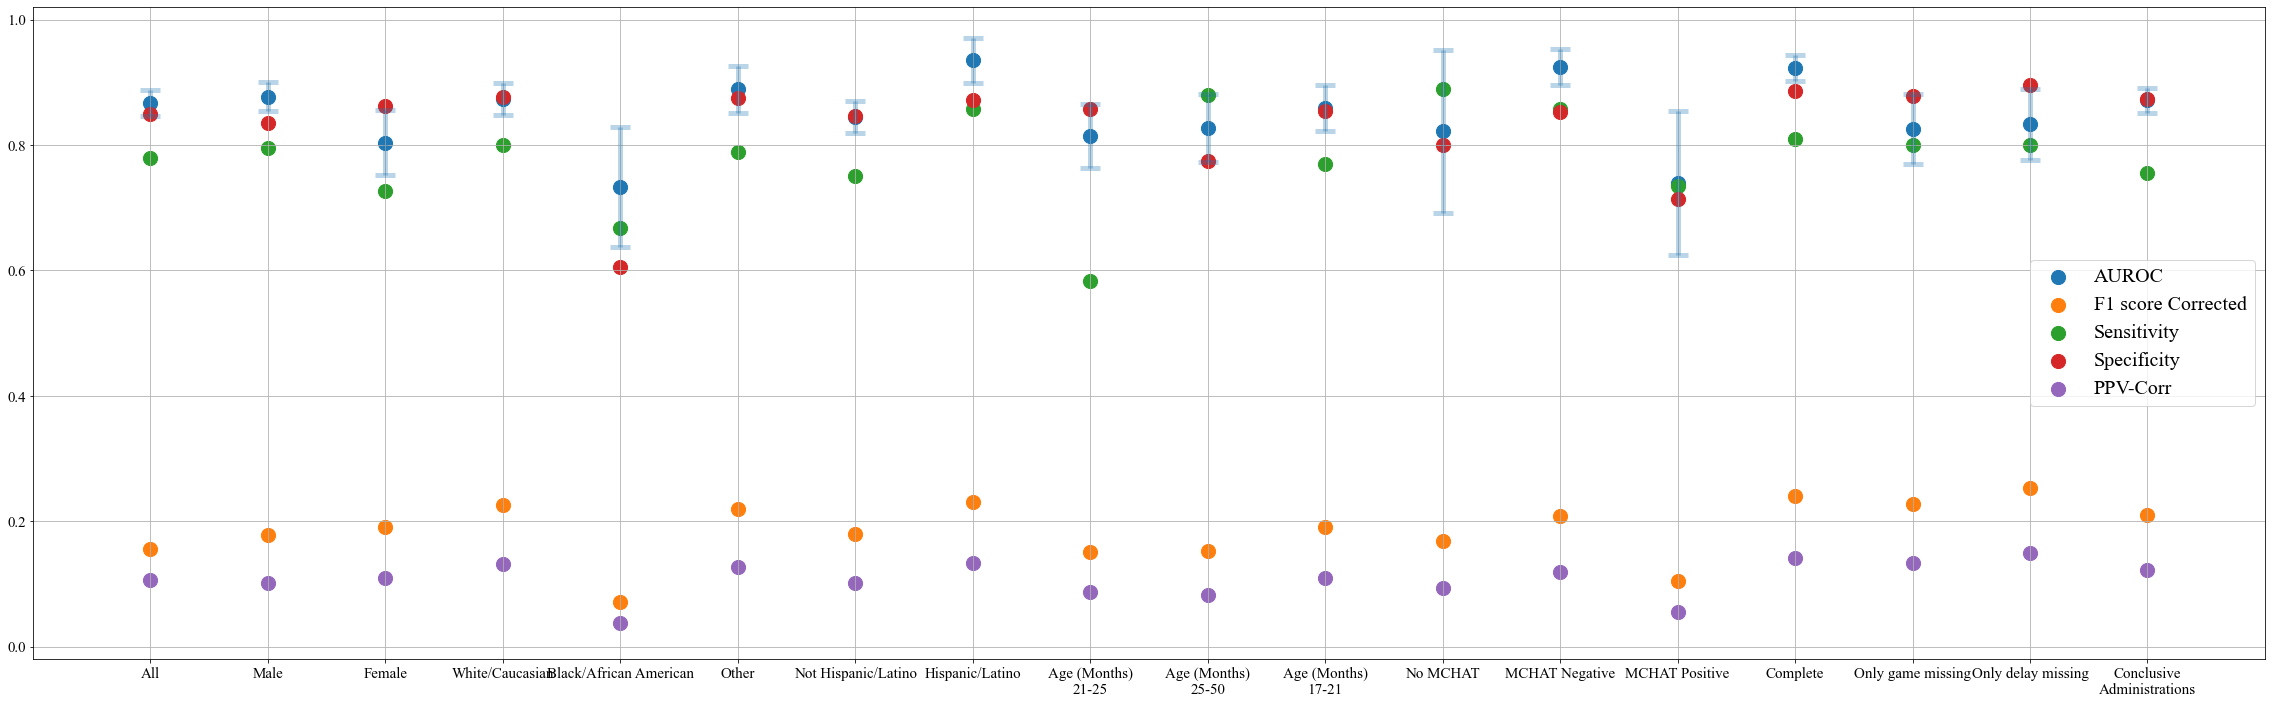

In [93]:
colors = plt.get_cmap('tab10')(np.arange(0,20))
rotate=0
savefig="Subgroups_analysis"
plt.rcParams["font.family"] = "Times New Roman"

condition = 'subgroup_raw'

order = ['All', 'Male', 'Female', 'White/Caucasian',
       'Black/African American', 'Other', 'Not Hispanic/Latino',
       'Hispanic/Latino', 'Age (Months)\n21-25', 'Age (Months)\n25-50',
       'Age (Months)\n17-21', 'No MCHAT', 'MCHAT Negative',
       'MCHAT Positive', 'Complete', 'Only game missing',
       'Only delay missing', 'Conclusive\nAdministrations']

fig = plt.figure(figsize=(40, 12));ax = plt.gca()
# loop over the curves (i.e. the metrics to be plotted)
for j, metric_name in enumerate(results_vertical['metric_name'].unique()):

    color = colors[j]
    # loop over the x ticks  (i.e. the condition that is varying)
    for i, condition_value in enumerate(order):

        if metric_name == 'AUROC':
            plt.errorbar([i], 
                         results_vertical[(results_vertical['metric_name']==metric_name) &
                                    (results_vertical[condition]==condition_value)]['score'],
                         yerr=results_vertical[(results_vertical['metric_name']==metric_name) &
                                    (results_vertical[condition]==condition_value)]['Hanley_CI'], 
                         fmt='',
                         ecolor='tab:blue',
                        # ecolor=color,
                         alpha=.3, 
                         capthick=5,
                         elinewidth=5,
                         capsize=10)
        plt.scatter([i], 
                     results_vertical[(results_vertical['metric_name']==metric_name) &
                                (results_vertical[condition]==condition_value)]['score'],
                     marker='o',
                     s=200,
                     label=metric_name if i==0 else None, color=color)

plt.grid(); #plt.title("Performances when using or not the inidcator variables", weight='bold')
#plt.ylabel(metric_name, weight='bold');
#plt.xlabel(condition, weight='bold');
plt.xlim([-1, len(results_vertical[condition].unique())]); plt.ylim([-0.02, 1.02])
plt.xticks(np.arange(len(results_vertical[condition].unique())), order, rotation=45 if rotate else 0, fontsize=15);
plt.yticks( fontsize=15);

plt.legend(prop={'size':20})
if savefig:
    os.makedirs(os.path.join(DATA_DIR, 'figures'), exist_ok=True)
    plt.savefig(os.path.join(DATA_DIR, 'figures', savefig+'.png'), dpi=200, bbox_inches = 'tight')


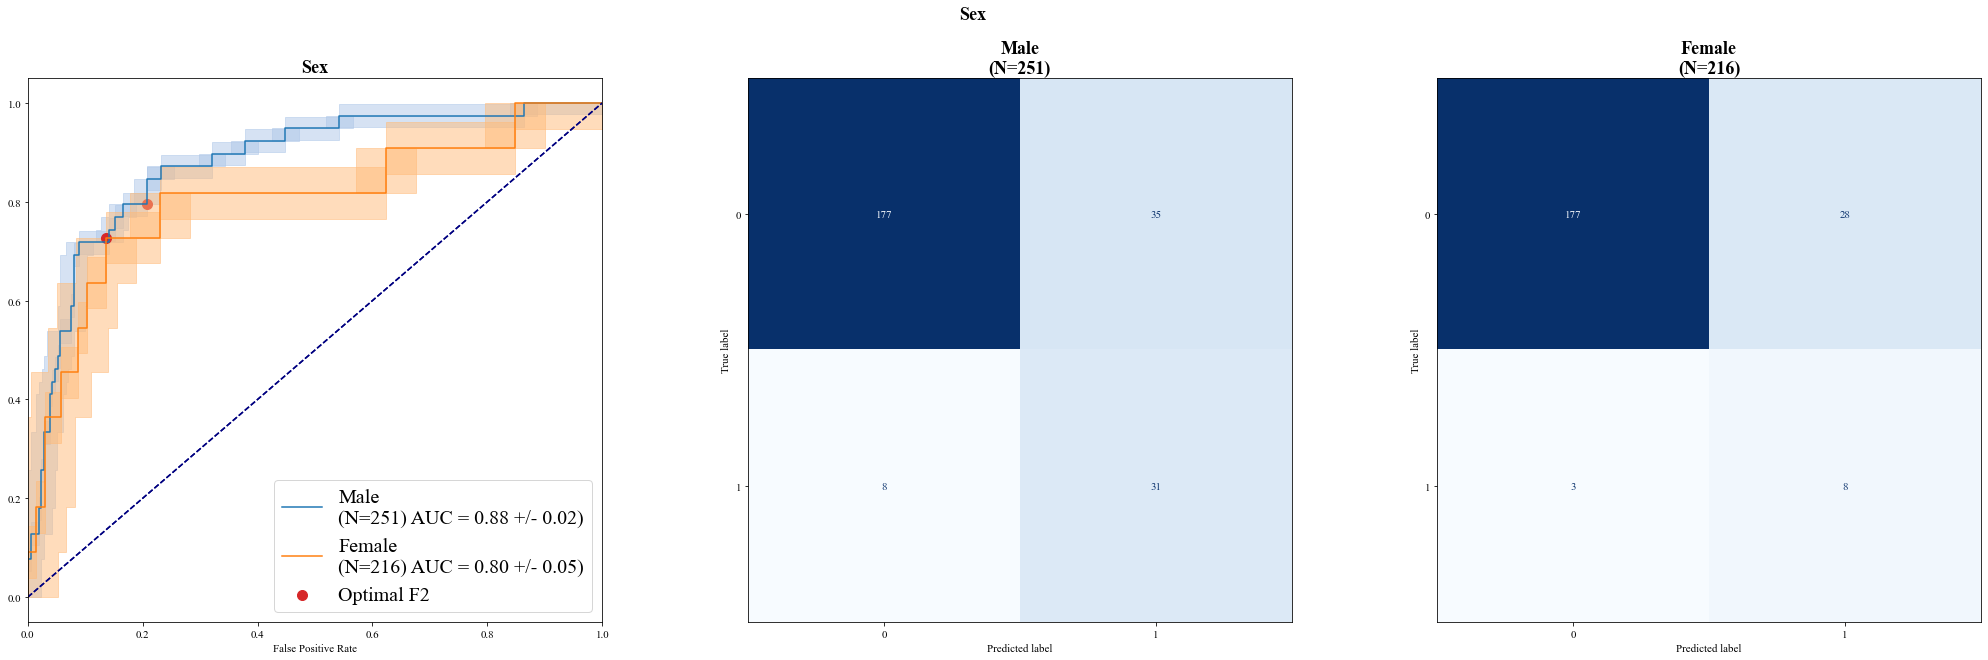

In [132]:
results_vertical['subgroup_raw'] = results_vertical['subgroup'].apply(lambda x: "\n".join(x.split('\n')[:-1]))

condition = 'subgroup_name'
colors = plt.get_cmap('tab20')(np.arange(0,20))

for comparisons_name, comparisons in zip(['Sex'],
                                         
                                         [['Male', 'Female']] ):
    
    d = results_vertical[results_vertical['subgroup_raw'].isin(comparisons)]
        
    fig, axes = plt.subplots(1, len(comparisons)+1, figsize=(35, 10))
    fig.suptitle(comparisons_name, weight='bold', fontsize=18)
    for i, comp in enumerate(comparisons):
        row = d[d['subgroup_raw'] == comp].iloc[0]
        
        
        # ROC CURVE
        y_true = row['y_true']
        y_pred = row['y_pred']


        fpr, tpr, thresholds = roc_curve(y_true, y_pred); roc_auc = auc(fpr, tpr)
        hanley_ci = compute_SD(roc_auc, np.sum(y_true==0), np.sum(y_true==1))

        axes[0].plot(fpr, tpr, '-', lw=1.5, label='{} AUC = {:.2f} +/- {:.2f})'.format(row['subgroup'], roc_auc, hanley_ci))
        axes[0].plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
        axes[0].set_xlim([0.0, 1.0]); axes[0].set_ylim([0.0, 1.05]); axes[0].grid()
        axes[0].set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate')
        
        tprs_upper = np.minimum(tpr + hanley_ci, 1);tprs_lower = np.maximum(tpr - hanley_ci, 0)
        axes[0].fill_between(fpr, tprs_lower, tprs_upper, color=colors[2*i + 1], alpha=.5)
        
        fpr_upper = np.minimum(fpr + hanley_ci, 1);fpr_lower = np.maximum(fpr - hanley_ci, 0)
        axes[0].fill_betweenx(tpr, fpr_lower, fpr_upper, color=colors[2*i + 1], alpha=.5)
        
        idx_threshold = np.argmin(np.abs(thresholds - exp.optimal_threshold))
        axes[0].scatter(fpr[idx_threshold], tpr[idx_threshold], color='tab:red', s=100, label="Optimal F2" if i==len(comparisons)-1 else None)
        
        axes[0].legend(loc='lower right', prop={'size':20})
        axes[0].set_title(comparisons_name, weight='bold', fontsize=18)
        
        
        # COnfusion matrix
        cm = np.array([[row['TN'], row['FP']], [row['FN'], row['TP']]]).astype(int)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues', ax=axes[i+1]);disp.im_.colorbar.remove()  
        axes[i+1].set_title("{}".format(row['subgroup']), weight='bold', fontsize=18)

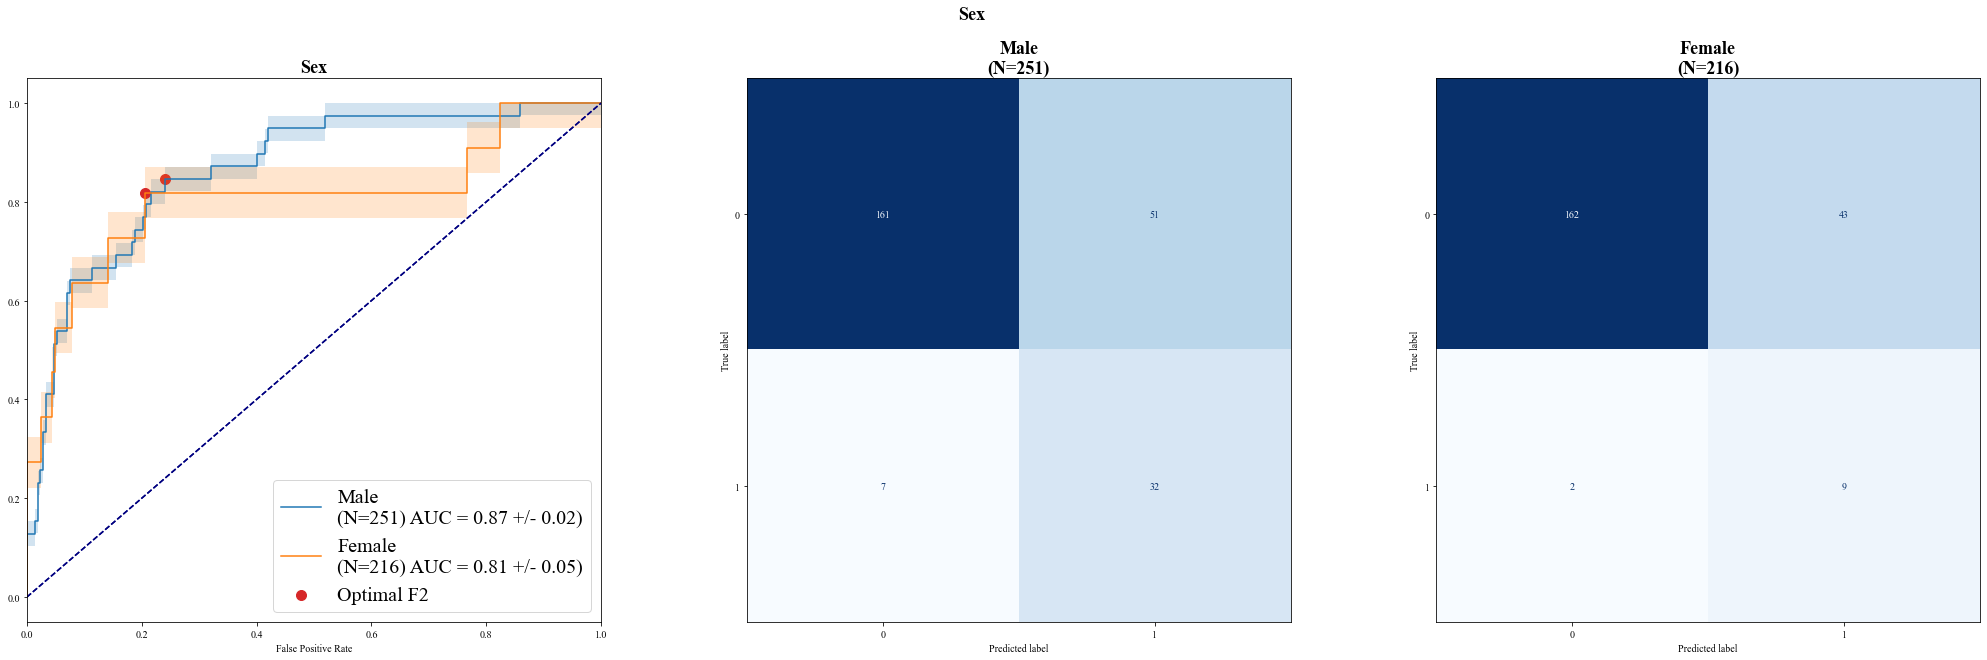

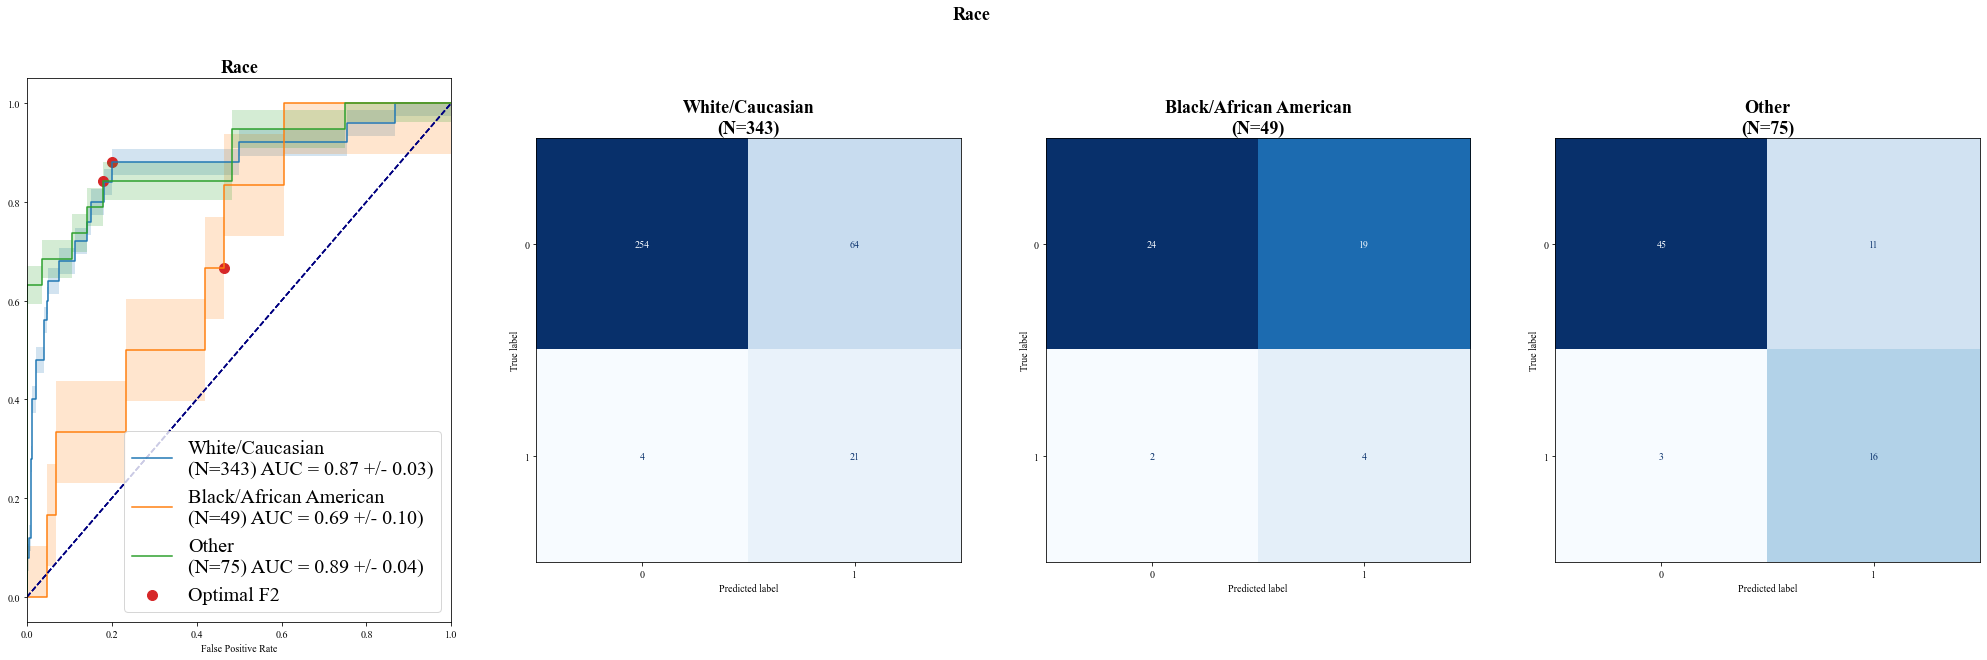

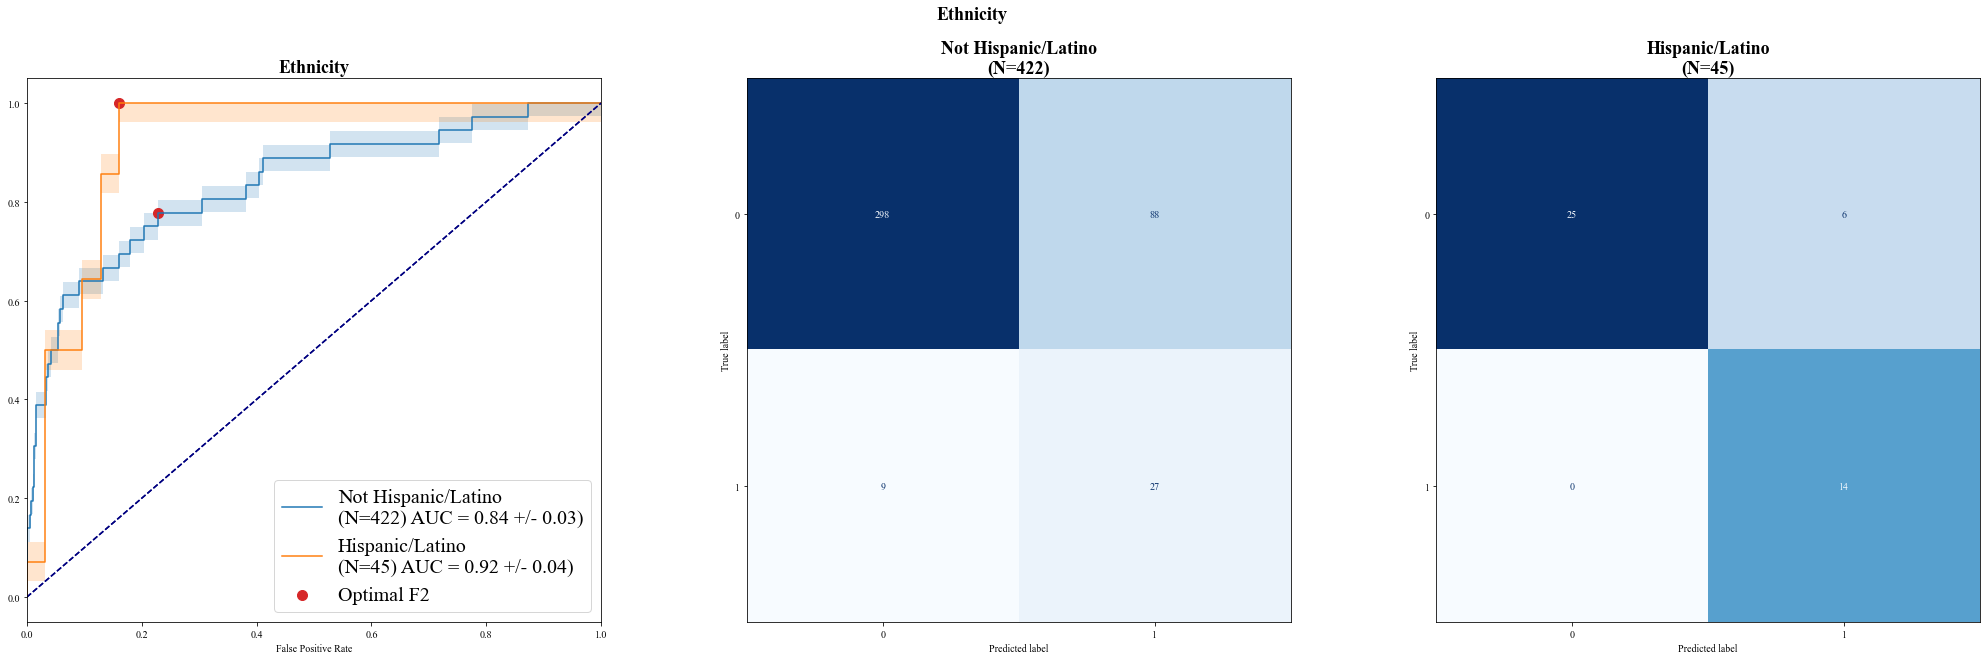

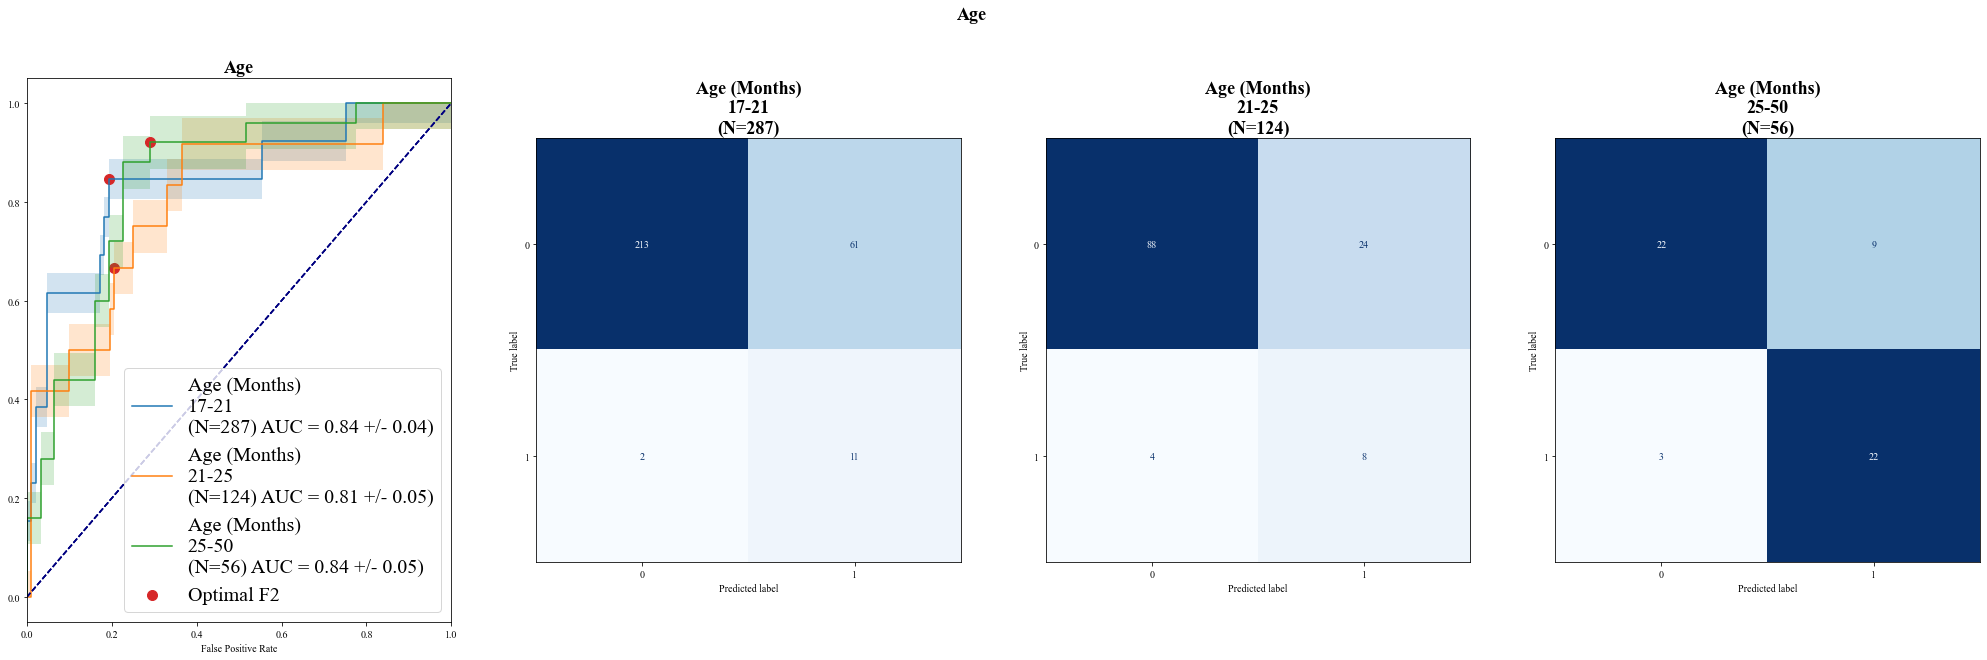

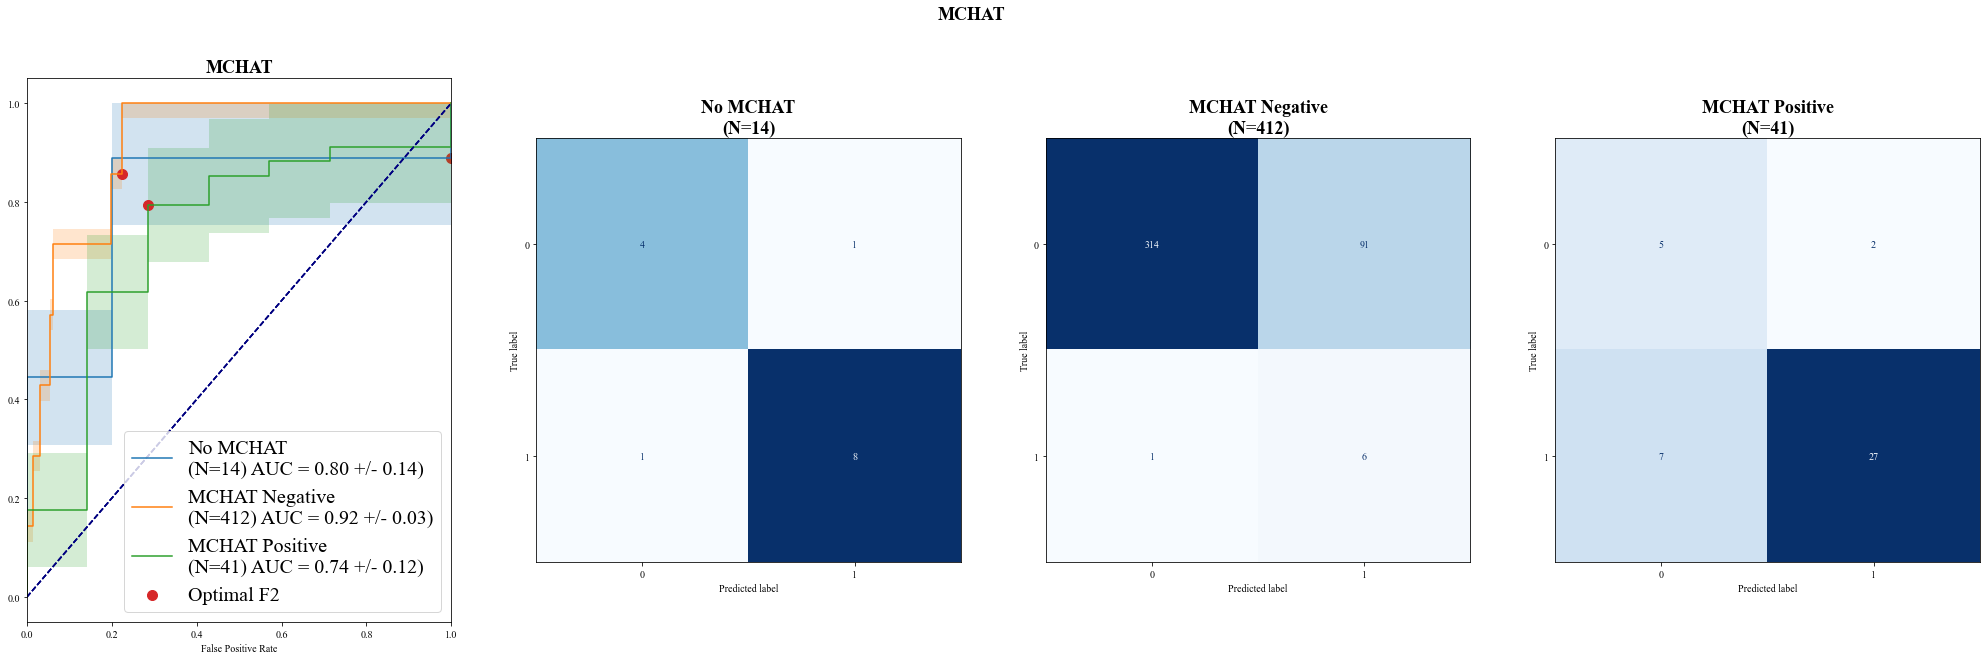

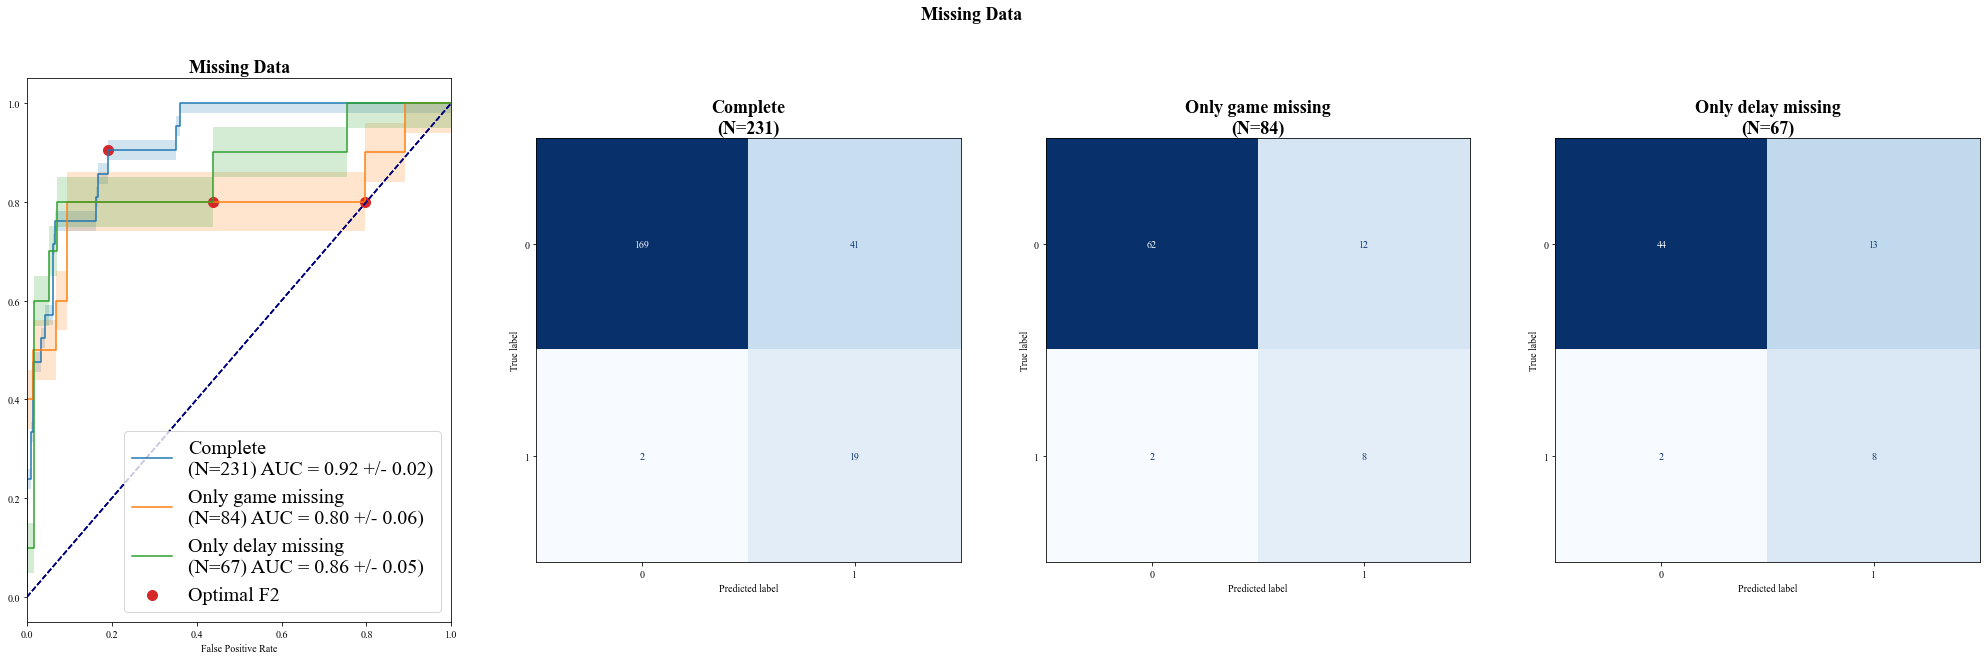

In [323]:
results_vertical['subgroup_raw'] = results_vertical['subgroup'].apply(lambda x: "\n".join(x.split('\n')[:-1]))

condition = 'subgroup_name'
for comparisons_name, comparisons in zip(['Sex', 'Race', 'Ethnicity', 'Age', 'MCHAT', 'Missing Data'],
                                         
                                         [['Male', 'Female'],
                                          ['White/Caucasian','Black/African American', 'Other'],
                                         ['Not Hispanic/Latino','Hispanic/Latino'], 
                                          ['Age (Months)\n17-21', 'Age (Months)\n21-25', 'Age (Months)\n25-50'],
                                          ['No MCHAT','MCHAT Negative', 'MCHAT Positive'],
                                         ['Complete', 'Only game missing','Only delay missing']] ):
    
    d = results_vertical[results_vertical['subgroup_raw'].isin(comparisons)]
        
    fig, axes = plt.subplots(1, len(comparisons)+1, figsize=(35, 10))
    fig.suptitle(comparisons_name, weight='bold', fontsize=18)
    for i, comp in enumerate(comparisons):
        row = d[d['subgroup_raw'] == comp].iloc[0]
        
        
        # ROC CURVE
        y_true = row['y_true']
        y_pred = row['y_pred']


        fpr, tpr, thresholds = roc_curve(y_true, y_pred); roc_auc = auc(fpr, tpr)
        hanley_ci = compute_SD(roc_auc, np.sum(y_true==0), np.sum(y_true==1))

        axes[0].plot(fpr, tpr, '-', lw=1.5, label='{} AUC = {:.2f} +/- {:.2f})'.format(row['subgroup'], roc_auc, hanley_ci))
        axes[0].plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
        axes[0].set_xlim([0.0, 1.0]); ax.set_ylim([0.0, 1.05]); axes[0].grid()
        axes[0].set_xlabel('False Positive Rate'); axes[0].set_ylabel('True Positive Rate')
        tprs_upper = np.minimum(tpr + hanley_ci, 1)
        tprs_lower = np.maximum(tpr - hanley_ci, 0)
        axes[0].fill_between(fpr, tprs_lower, tprs_upper,  alpha=.2)
        idx_threshold = np.argmin(np.abs(thresholds - exp.optimal_threshold))
        axes[0].scatter(fpr[idx_threshold], tpr[idx_threshold], color='tab:red', s=100, label="Optimal F2" if i==len(comparisons)-1 else None)
        
        axes[0].legend(loc='lower right', prop={'size':20})
        axes[0].set_title(comparisons_name, weight='bold', fontsize=18)
        
        
        # COnfusion matrix
        cm = np.array([[row['TN'], row['FP']], [row['FN'], row['TP']]]).astype(int)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues', ax=axes[i+1]);disp.im_.colorbar.remove()  
        axes[i+1].set_title("{}".format(row['subgroup']), weight='bold', fontsize=18)

Text(0, 0.5, 'True Positive Rate')

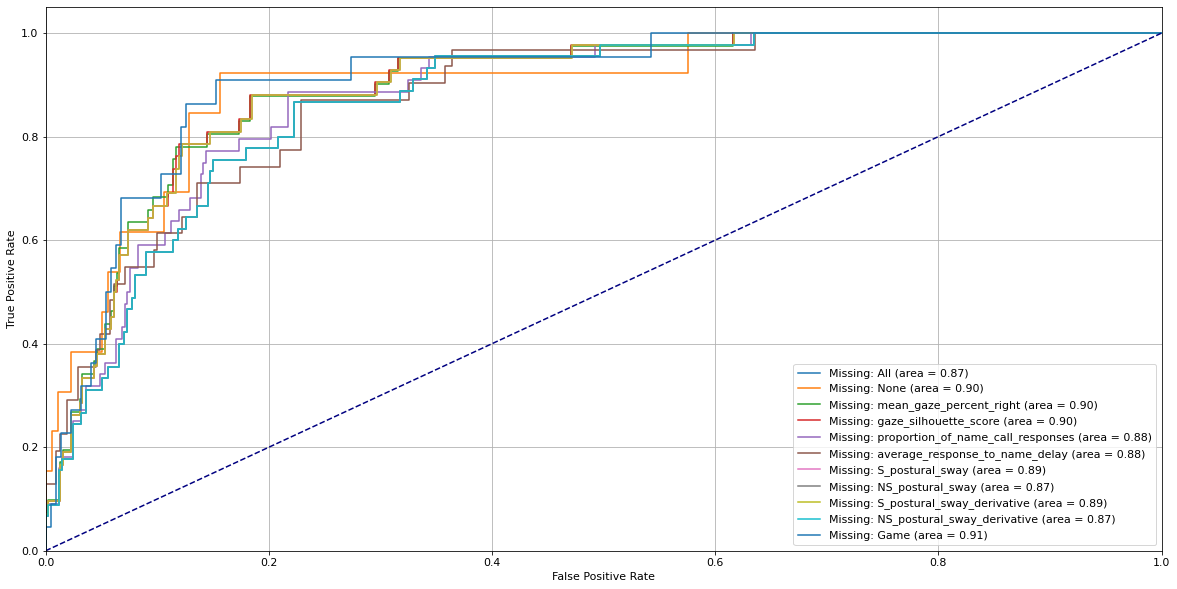

In [240]:
fig, ax =  plt.subplots(1, 1, figsize=(20, 10))


for missing, variables in grouped_missing_features.items():
    
    d=dataframe.dropna(subset=variables, how='any') 

    
    title = missing
    y_true = d['y_true'].to_numpy()
    y_pred = d['y_pred'].to_numpy()
    
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, '-', lw=1.5, label='Missing: {} (area = {:.2f})'.format(missing, roc_auc))


ax.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
ax.legend()
ax.set_xlim([0.0, 1.0]); ax.set_ylim([0.0, 1.05]); ax.grid()
ax.set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate')

In [243]:
results

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TP_normalized,FN,FN_normalized,TN,TN_normalized,FP,FP_normalized,N
All,0.873,0.430,0.872,0.187,0.967,0.482,0.217,0.841,0.443,0.756,0.850,0.354,0.970,0.244,0.646,0.030,34,7.000000,11,2.000000,351,77.000000,62,14.000000,458
All,0.873,0.430,0.872,0.187,0.967,0.482,0.217,0.841,0.443,0.756,0.850,0.354,0.970,0.244,0.646,0.030,34,0.074236,11,0.024017,351,0.766376,62,0.135371,458
None,0.899,0.503,0.970,0.327,0.990,0.485,0.344,0.865,0.463,0.846,0.866,0.314,0.987,0.154,0.686,0.013,11,0.057292,2,0.010417,155,0.807292,24,0.125000,192
mean_gaze_percent_right,0.896,0.477,0.891,0.218,0.973,0.542,0.264,0.871,0.501,0.780,0.880,0.405,0.975,0.220,0.595,0.025,32,0.073733,9,0.020737,346,0.797235,47,0.108295,434
gaze_silhouette_score,0.895,0.476,0.886,0.214,0.972,0.541,0.259,0.871,0.508,0.786,0.880,0.412,0.975,0.214,0.588,0.025,33,0.075862,9,0.020690,346,0.795402,47,0.108046,435
proportion_of_name_call_responses,0.881,0.442,0.876,0.194,0.968,0.500,0.229,0.848,0.461,0.773,0.856,0.366,0.972,0.227,0.634,0.028,34,0.074890,10,0.022026,351,0.773128,59,0.129956,454
average_response_to_name_delay,0.877,0.478,0.932,0.257,0.984,0.486,0.274,0.848,0.418,0.710,0.861,0.338,0.967,0.290,0.662,0.033,22,0.064516,9,0.026393,267,0.782991,43,0.126100,341
S_postural_sway,0.895,0.475,0.886,0.213,0.972,0.537,0.259,0.869,0.504,0.786,0.878,0.407,0.975,0.214,0.593,0.025,33,0.075688,9,0.020642,346,0.793578,48,0.110092,436
NS_postural_sway,0.873,0.430,0.872,0.187,0.967,0.482,0.217,0.841,0.443,0.756,0.850,0.354,0.970,0.244,0.646,0.030,34,0.074236,11,0.024017,351,0.766376,62,0.135371,458
S_postural_sway_derivative,0.895,0.475,0.886,0.213,0.972,0.537,0.259,0.869,0.504,0.786,0.878,0.407,0.975,0.214,0.593,0.025,33,0.075688,9,0.020642,346,0.793578,48,0.110092,436
